In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import yfinance as yf

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar import vecm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
#from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import *

In [202]:
data = pd.read_excel('Assignment 2 Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')
#display(data)

spy_data = data[['Date', 'GDP', 'PCEPI', 'M2SL', 'SPX Total', '10Y Treasury', 'Futures Shock', 'SPX Shock', 'Unemployment', 'FEDFUNDS']].dropna()
spy_data.set_index('Date', inplace=True)

#Transaform monetary variables into real terms
spy_data['M2SL'] = spy_data['M2SL'] / spy_data['PCEPI']
spy_data['GDP'] = spy_data['GDP'] / spy_data['PCEPI']
spy_data['SPX Total'] = spy_data['SPX Total'] / spy_data['PCEPI']

display(spy_data)

,GDP,PCEPI,M2SL,SPX Total,10Y Treasury,Futures Shock,SPX Shock,Unemployment,FEDFUNDS
Date,,,,,,,,,
1992-01-01,100.828970,62.638,53.980012,6.526390,7.03,0.000000,0.00000,7.3,4.03
1992-02-01,101.223052,62.797,54.142714,6.571970,7.34,0.004572,0.03621,7.4,4.06
1992-03-01,101.940889,62.949,54.073933,6.413128,7.54,0.000000,0.00000,7.4,3.98
1992-04-01,102.081101,63.119,53.861753,6.573298,7.48,-0.258935,0.61127,7.4,3.73
1992-05-01,101.795959,63.203,53.772764,6.572473,7.39,0.012382,-0.04802,7.6,3.82
...,...,...,...,...,...,...,...,...,...
2023-09-01,229.449710,121.267,170.781004,35.360815,4.38,0.051324,-0.17053,3.8,5.33
2023-10-01,228.610941,121.309,170.627901,34.571219,4.80,0.000000,0.00000,3.8,5.33
2023-11-01,230.418379,121.296,170.862188,37.658290,4.50,-0.013891,0.01259,3.7,5.33


[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'S&P 500 Price')

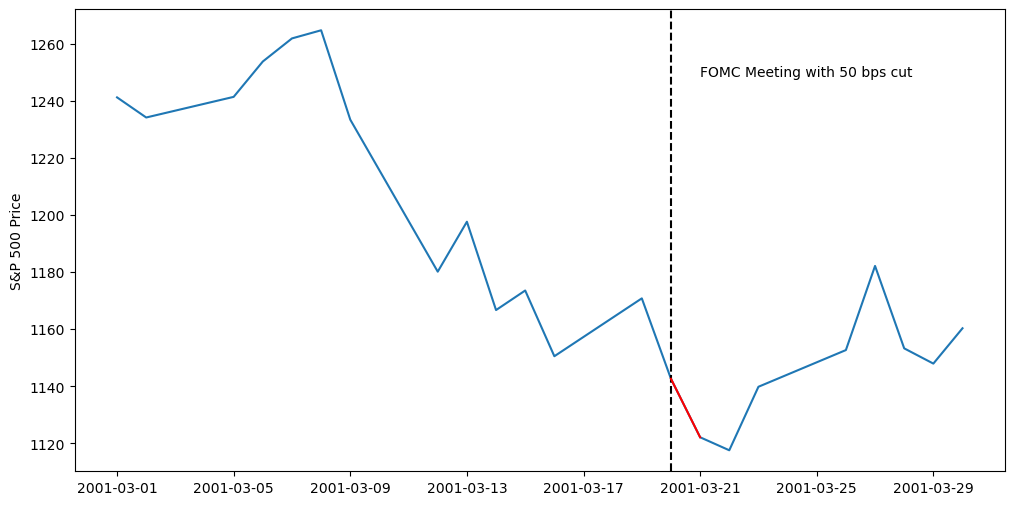

In [203]:
# Use yfinance to download the S&P 500 index between 15 Feb 2001 and 15 March 2001

start_date = '2001-03-01'
end_date = '2001-03-31'
spx = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']

plt.figure(figsize=(12, 6))
plt.plot(spx)

# Find the next trading day after 3 March 2001
fomc_date = pd.Timestamp('2001-03-20')

# Add a black vertical line at the date of the FOMC meeting
plt.axvline(x=fomc_date, color='black', linestyle='--')

#label the dotted line as the FOMC meeting with rate cut, move the label a few pixels to the right
plt.text(pd.Timestamp('2001-03-21'), 1250, 'FOMC Meeting with 50 bps cut',verticalalignment='center')

#plot a red line for the price change on the fomc meeting day and the following day
signal = spx.loc[[fomc_date, fomc_date + pd.Timedelta(days=1)]]  # Select the price on the FOMC meeting day and the following day
plt.plot(signal.index, signal, color='red')

#label y axis S&P 500 Price
plt.ylabel('S&P 500 Price')

Text(0.15, -1.5, 'IV: 78')

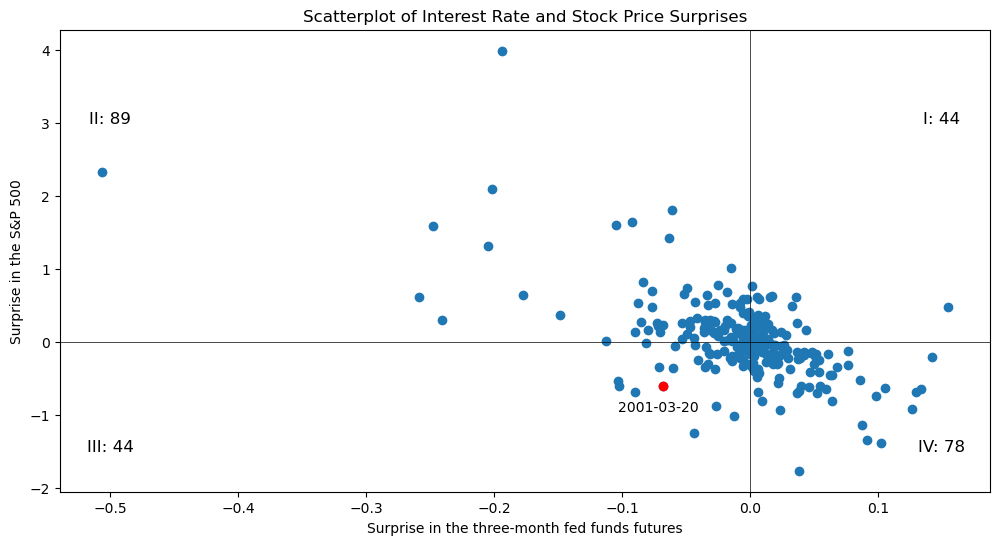

In [235]:
shocks = spy_data[['Futures Shock', 'SPX Shock']]

#Create scatter plot of the shocks
plt.figure(figsize=(12, 6))
plt.scatter(shocks['Futures Shock'], shocks['SPX Shock'])
plt.xlabel('Surprise in the three-month fed funds futures')
plt.ylabel('Surprise in the S&P 500')
plt.title('Scatterplot of Interest Rate and Stock Price Surprises')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

#Make the scatter plot of the shocks with the FOMC meeting day in red
fomc_date = pd.Timestamp('2001-03-01')
signal = shocks.loc[[fomc_date]]
plt.scatter(signal['Futures Shock'], signal['SPX Shock'], color='red')
plt.text(-0.04, -1, '2001-03-20', verticalalignment='bottom', horizontalalignment='right')


#Count the number of observations in each quadrant
quadrants = np.sign(shocks)
quadrants['count'] = 1
quadrants = quadrants.groupby(['Futures Shock', 'SPX Shock']).count().reset_index()
quadrants = quadrants.pivot(index='SPX Shock', columns='Futures Shock', values='count').fillna(0)
quadrants = quadrants.astype(int)

#label each quadrant I, II, III, IV
plt.text(0.15, 3, f'I: {quadrants.loc[1,1]}', fontsize=12, ha='center')
plt.text(-0.5, 3, f'II: {quadrants.loc[1,-1]}', fontsize=12, ha='center')
plt.text(-0.5, -1.5, f'III: {quadrants.loc[-1,-1]}', fontsize=12, ha='center')
plt.text(0.15, -1.5, f'IV: {quadrants.loc[-1,1]}', fontsize=12, ha='center')

2.0

In [221]:

quadrants

Futures Shock,-1.0,0.0,1.0
SPX Shock,,,
-1.0,44.0,2.0,78.0
0.0,0.0,122.0,0.0
1.0,89.0,2.0,44.0


In [ ]:
# ADF TEST
# List of column names to check for stationarity
columns_to_check = ['GDP', 'PCEPI', 'M2SL', 'SPX Total', '10Y Treasury', 'Futures Shock', 'SPX Shock', 'Unemployment', 'FEDFUNDS']

# Function to run ADF test and print results
def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF Test for {column_name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value}')
    print('\n')

# Apply the ADF test to each column
for col in columns_to_check:
    adf_test(spy_data[col], col)

ADF Test for GDP:
ADF Statistic: 0.4883346528802354
p-value: 0.9845141914723283
Critical Values:
    1%: -3.447909006729481
    5%: -2.8692783343881483
    10%: -2.5708923751111112


ADF Test for PCEPI:
ADF Statistic: 2.341392830693939
p-value: 0.9989800029960746
Critical Values:
    1%: -3.4478619826418817
    5%: -2.869257669826291
    10%: -2.570881358363513


ADF Test for M2SL:
ADF Statistic: -0.2730176091895635
p-value: 0.9292398631838106
Critical Values:
    1%: -3.4480996560263386
    5%: -2.8693621113224137
    10%: -2.570937038891028


ADF Test for SPX Total:
ADF Statistic: 0.43548732629967124
p-value: 0.982774617712826
Critical Values:
    1%: -3.4477224095888497
    5%: -2.869196333125208
    10%: -2.5708486586002604


ADF Test for 10Y Treasury:
ADF Statistic: -2.212598075011654
p-value: 0.20170489703028505
Critical Values:
    1%: -3.4478152097574224
    5%: -2.8692371153451903
    10%: -2.5708704003405356


ADF Test for Futures Shock:
ADF Statistic: -6.26718897644418
p-val

In [ ]:
# List of columns to check for stationarity
#columns_to_check = ['Futures Shock', 'M2SL', 'PCEPI', 'FEDFUNDS', 'GDP', 'Unemployment', 'SPX Total']
columns_to_check = ['Futures Shock', 'SPX Shock', 'M2SL', 'PCEPI', '10Y Treasury', 'Unemployment', 'GDP', 'SPX Total']

# Function to conduct ADF tests and identify non-stationary variables
def check_stationarity(data):
    non_stationary_cols = []
    for col in columns_to_check:
        result = adfuller(data[col].dropna())
        if result[1] > 0.05:  # p-value greater than 0.05 indicates non-stationarity
            non_stationary_cols.append(col)
        print(f"{col}: ADF Statistic = {result[0]}, p-value = {result[1]}")
    return non_stationary_cols

non_stationary_cols = check_stationarity(spy_data)
print(f"Non-stationary columns: {non_stationary_cols}")

Futures Shock: ADF Statistic = -6.26718897644418, p-value = 4.0867502239440795e-08
SPX Shock: ADF Statistic = -10.939377958721089, p-value = 9.380401628747977e-20
M2SL: ADF Statistic = -0.2730176091895635, p-value = 0.9292398631838106
PCEPI: ADF Statistic = 2.341392830693939, p-value = 0.9989800029960746
10Y Treasury: ADF Statistic = -2.212598075011654, p-value = 0.20170489703028505
Unemployment: ADF Statistic = -3.411255257193174, p-value = 0.010581112705149992
GDP: ADF Statistic = 0.4883346528802354, p-value = 0.9845141914723283
SPX Total: ADF Statistic = 0.43548732629967124, p-value = 0.982774617712826
Non-stationary columns: ['M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'SPX Total']


In [ ]:
spy_data_diff = spy_data.copy()

# Apply differencing
for col in ['GDP', 'PCEPI', 'M2SL', 'SPX Total']:
    spy_data_diff[col] = np.log(spy_data[col]).diff()

#for col in ['FEDFUNDS']:
for col in ['10Y Treasury']:
    spy_data_diff[col] = spy_data[col].diff()

spy_data_diff.dropna(inplace=True)

In [ ]:
#Put all the stationarity test results in a table with the adf statistic and p-values
adf_results = []
for col in columns_to_check:
    result = adfuller(spy_data_diff[col])
    adf_results.append([col, result[0], result[1]])
adf_results = pd.DataFrame(adf_results, columns=['Variable', 'ADF Statistic', 'p-value'])

# export as an xlsx file
adf_results.to_excel('adf_results.xlsx')

In [ ]:
# Reorder the columns so that 'Futures Shock' is first
#ordered_columns = ['Futures Shock', 'M2SL', 'PCEPI', 'FEDFUNDS', 'GDP', 'Unemployment', 'SPX Total']
ordered_columns = ['Futures Shock', 'SPX Shock', 'M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'Unemployment', 'SPX Total']
spy_data_ordered = spy_data_diff[ordered_columns]
print(spy_data_ordered)

            Futures Shock  SPX Shock      M2SL     PCEPI  10Y Treasury  \
Date                                                                     
1992-02-01       0.004572    0.03621  0.003010  0.002535          0.31   
1992-03-01       0.000000    0.00000 -0.001271  0.002418          0.20   
1992-04-01      -0.258935    0.61127 -0.003932  0.002697         -0.06   
1992-05-01       0.012382   -0.04802 -0.001654  0.001330         -0.09   
1992-06-01       0.000000    0.00000 -0.003302  0.001770         -0.13   
...                   ...        ...       ...       ...           ...   
2023-09-01       0.051324   -0.17053 -0.006404  0.003834          0.21   
2023-10-01       0.000000    0.00000 -0.000897  0.000346          0.42   
2023-11-01      -0.013891    0.01259  0.001372 -0.000107         -0.30   
2023-12-01      -0.051664    0.66225  0.001696  0.001252         -0.48   
2024-01-01       0.021353   -0.30595 -0.003567  0.003764          0.04   

                 GDP  Unemployment  S

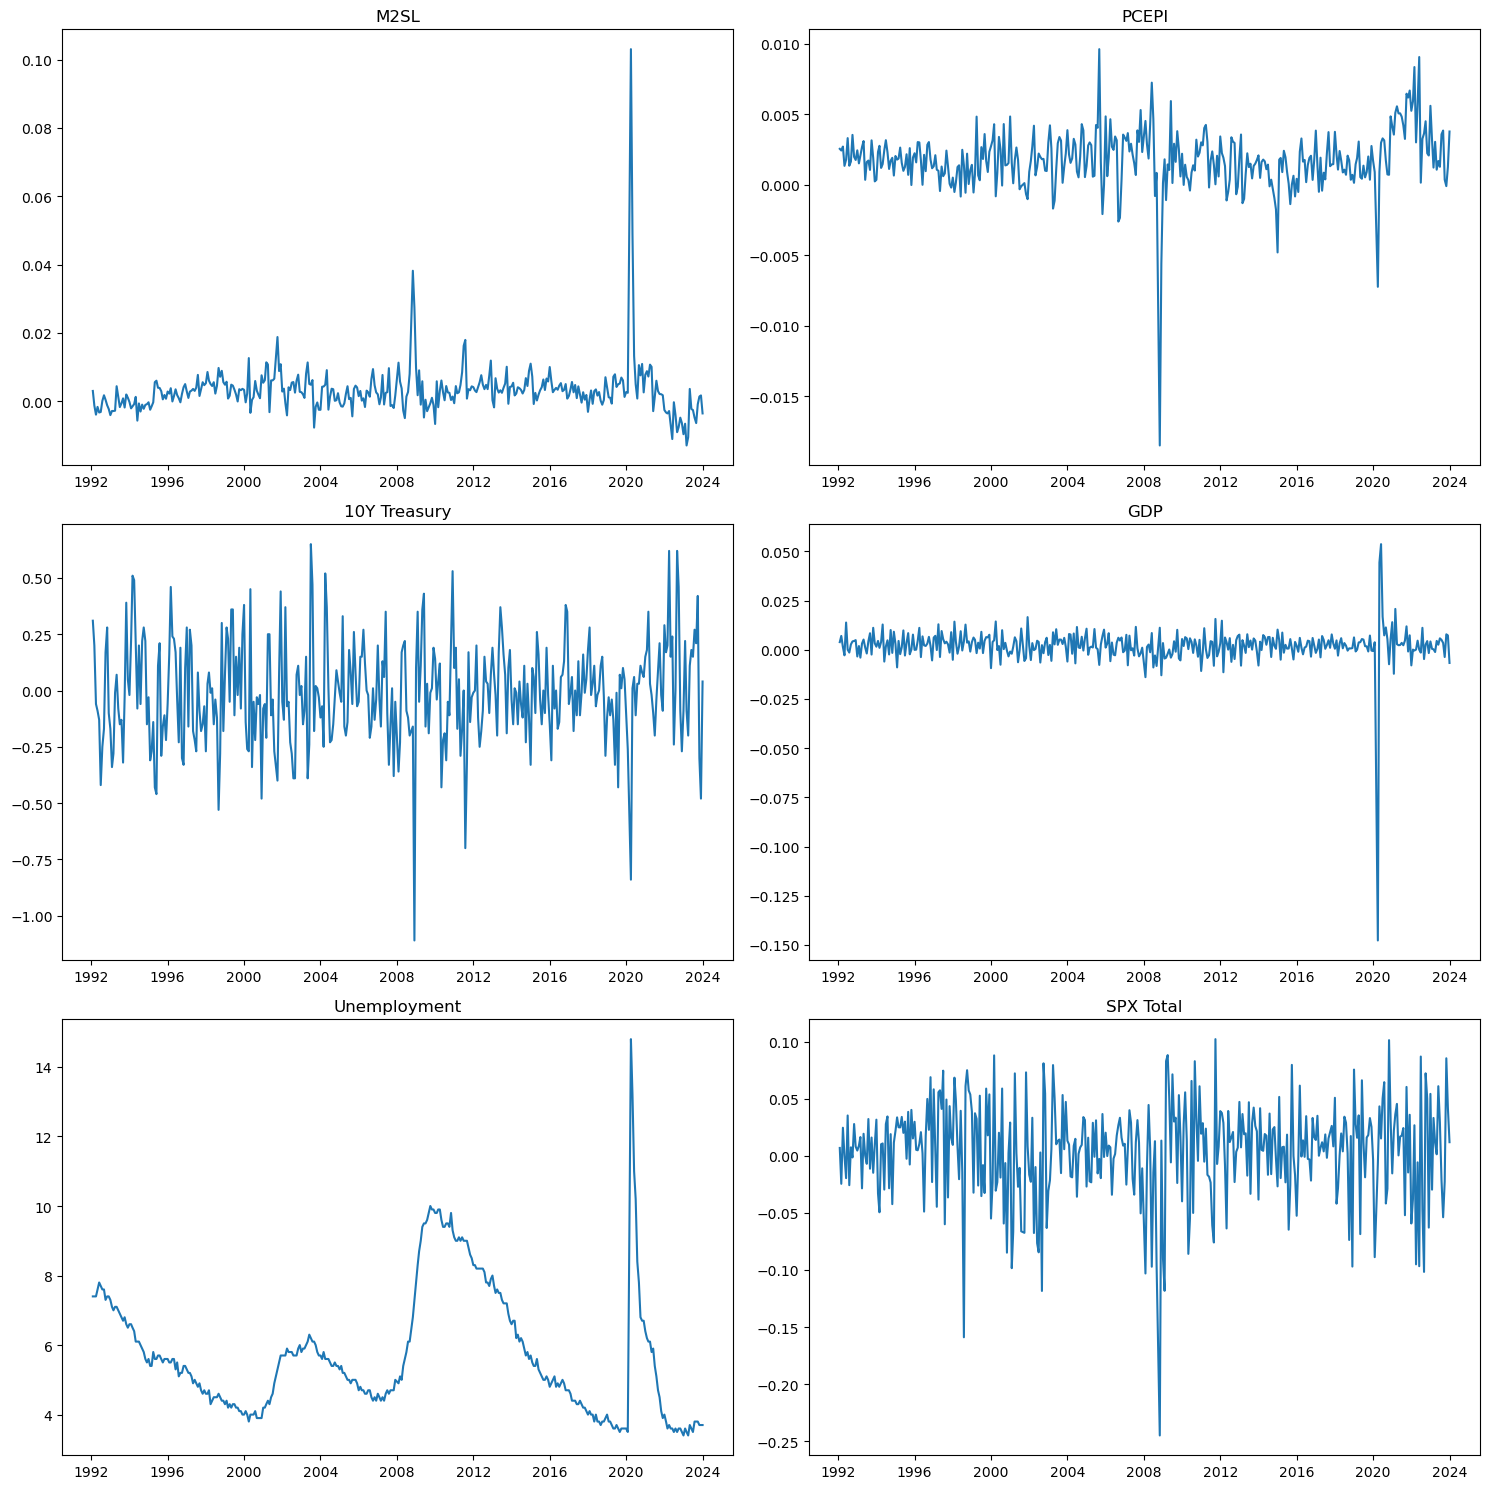

In [ ]:
#Plot 'M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'Unemployment', 'SPX Total'
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for i, col in enumerate(['M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'Unemployment', 'SPX Total']):
    ax = axs[i//2, i%2]
    ax.plot(spy_data_ordered[col])
    ax.set_title(col)

plt.tight_layout()

In [ ]:
# Initialize and fit the VAR model
model_var = VAR(spy_data_ordered)
lag_selection = model_var.select_order(maxlags=20)
optimal_lags = lag_selection.aic

# Fit the VAR model with the chosen lag length
var_results = model_var.fit(optimal_lags)
print(var_results.summary())

#fevd = var_results.fevd() works for VAR but not SVAR
#fevd.plot(10)

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, May, 2024
Time:                     10:52:16
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -51.1868
Nobs:                     378.000    HQIC:                  -52.0407
Log likelihood:           5787.01    FPE:                1.42960e-23
AIC:                     -52.6025    Det(Omega_mle):     1.00548e-23
--------------------------------------------------------------------
Results for equation Futures Shock
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.007193         0.010071           -0.714           0.475
L1.Futures Shock         0.075406         0.062795            1.201           0.230
L1.SPX Shock             0.012339       

In [ ]:
def create_industry_dfs(treated_vars, industry_names, shock_vars, endog_vars, exog_vars):
    industry_dfs = {}
    for industry in industry_names:
        shock_df = treated_vars[shock_vars]
        endog_df = treated_vars[endog_vars]
        exog_df = treated_vars[exog_vars]
        industry_dfs[industry] = {'m': shock_df, 'y': endog_df, 'w': exog_df}
    return industry_dfs

In [ ]:
industry_names = ['SPX Total']
shock_vars = ['Futures Shock', 'SPX Shock']
endog_vars = ['M2SL', 'PCEPI', '10Y Treasury', 'GDP', 'SPX Total']
exog_vars = [ 'Unemployment']
industry_dfs = create_industry_dfs(spy_data_ordered, industry_names, shock_vars, endog_vars, exog_vars)
data = industry_dfs['SPX Total']

In [ ]:
sigma

,Futures Shock,SPX Shock,M2SL,PCEPI,10Y Treasury,GDP,Unemployment,SPX Total
Futures Shock,0.002538,-0.013269,-0.000024,0.000008,0.000244,-0.000004,-0.000870,-0.000305
SPX Shock,-0.013269,0.209741,0.000136,-0.000057,0.001430,0.000068,0.000411,0.003381
M2SL,-0.000024,0.000136,0.000042,-0.000006,-0.000346,-0.000039,0.003063,-0.000023
PCEPI,0.000008,-0.000057,-0.000006,0.000004,0.000059,0.000002,-0.000274,0.000008
10Y Treasury,0.000244,0.001430,-0.000346,0.000059,0.042742,0.000296,-0.019704,0.000520
GDP,-0.000004,0.000068,-0.000039,0.000002,0.000296,0.000086,-0.004736,0.000037
Unemployment,-0.000870,0.000411,0.003063,-0.000274,-0.019704,-0.004736,0.376433,-0.001245
SPX Total,-0.000305,0.003381,-0.000023,0.000008,0.000520,0.000037,-0.001245,0.001863


In [ ]:
# Extract posterior results
beta = var_results.coefs
sigma = var_results.sigma_u
T = spy_data_ordered.shape[0]
N = spy_data_ordered.shape[1]
ndraws = 1


# Assuming 'ndraws' is the number of posterior draws
beta_draws = np.empty((beta.shape[0], beta.shape[1], ndraws))
sigma_draws = np.empty((sigma.shape[0], sigma.shape[1], ndraws))

for i in range(ndraws):
    # Simulate residuals
    residuals = np.random.multivariate_normal(np.zeros(N), sigma, T)

    # Simulate data
    simulated_data = np.zeros((T, N))
    simulated_data[:optimal_lags, :] = data['y'].values[:optimal_lags]
    for t in range(optimal_lags, T):
        lagged_data = np.concatenate([simulated_data[t-1:t-optimal_lags-1:-1, :], data['w'][t-1:t-optimal_lags-1:-1, :]], axis=1)
        simulated_data[t, :] = np.dot(beta.T, lagged_data[t, :]) + residuals[t, :]

    # Fit VAR model to simulated data
    model = VAR(pd.DataFrame(simulated_data, columns=df.columns))
    results = model.fit(maxlags=optimal_lags)

    # Store posterior draws
    beta_draws[:, :, i] = results.coefs
    sigma_draws[:, :, i] = results.sigma_u

ValueError: could not broadcast input array from shape (2,5) into shape (2,8)

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


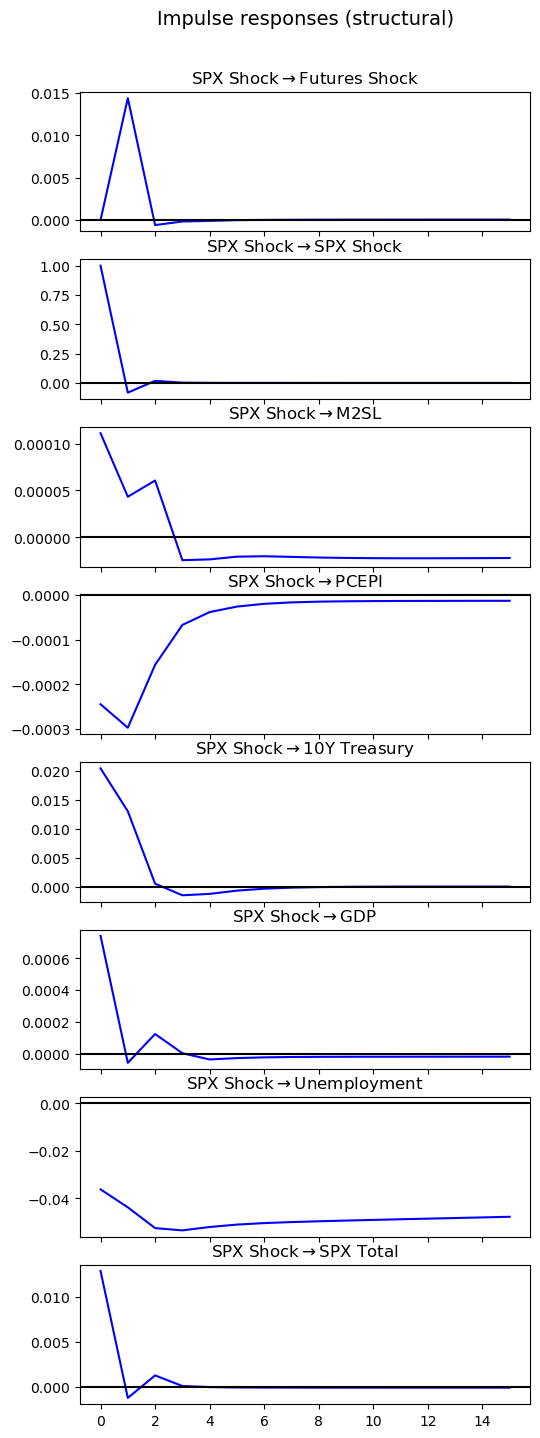

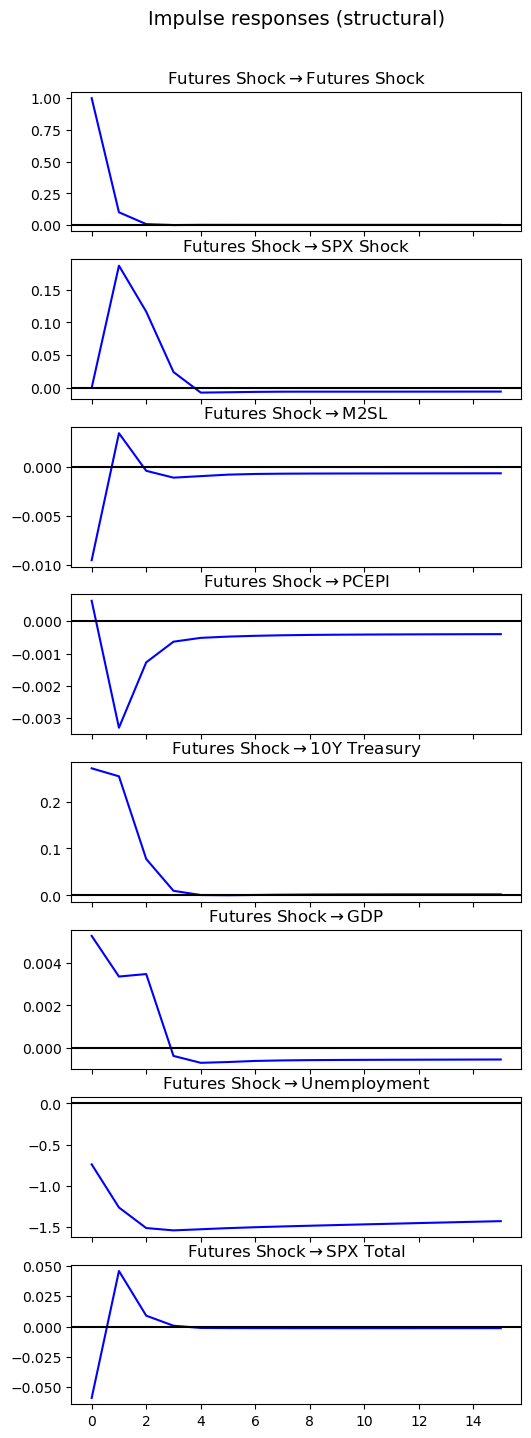

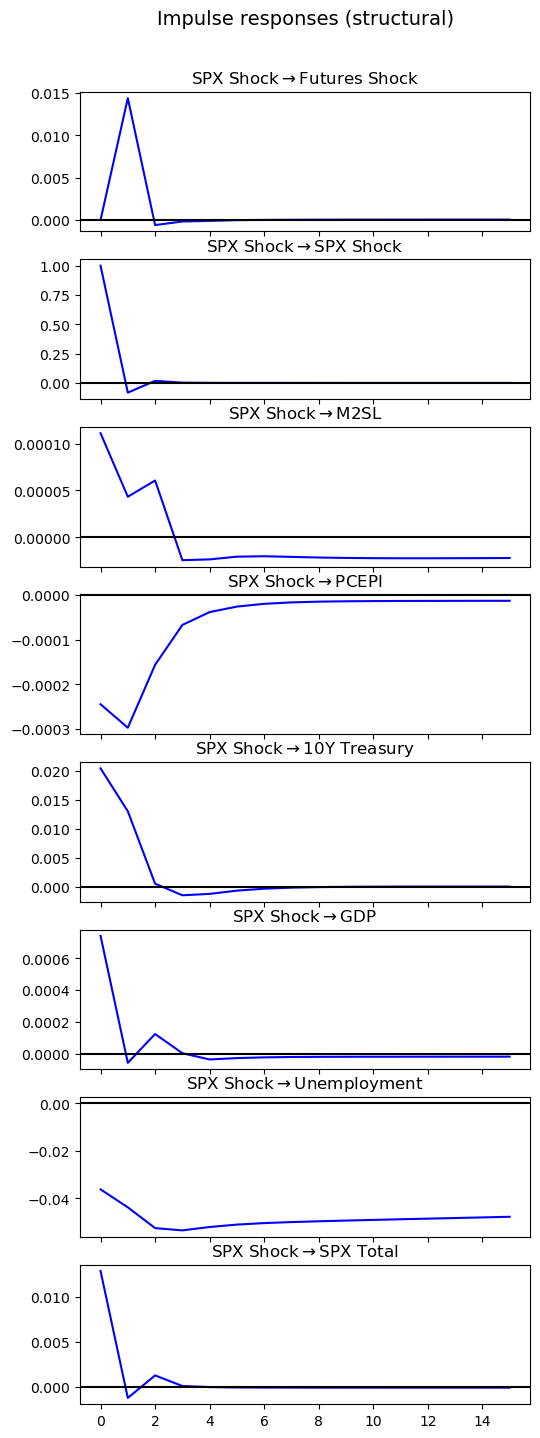

In [ ]:
import numpy as np
from statsmodels.tsa.vector_ar.svar_model import SVAR, SVARResults

# Identification matrix to enforce the zero-lag impact on m_t
A = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],  # Futures Shock (exogenous)
    [0, 1, 0, 0, 0, 0, 0, 0],  # SPX Shock (exogenous)
    ['E', 'E', 1, 0, 0, 0, 0, 0],  # M2SL influenced by Futures Shock
    ['E', 'E', 'E', 1, 0, 0, 0, 0],  # PCEPI depends on Futures Shock and M2SL
    ['E', 'E', 'E', 'E', 1, 0, 0, 0],  # FEDFUNDS depends on prior variables or 10Y Treasury too
    ['E', 'E', 'E', 'E', 'E', 1, 0, 0],  # GDP depends on prior variables
    ['E', 'E', 'E', 'E', 'E', 'E', 1, 0],  # Unemployment depends on prior variables
    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 1]   # SPX Total depends on all prior variables
])

# Model misspecification ? Not sure on the correct order

# Fit the SVAR model with the identification matrix
model_svar = SVAR(spy_data_ordered, svar_type='A', A=A)
svar_results = model_svar.fit(trend='n') # not sure if 'c' or 'ctt'

# Generate and plot the IRFs, only the effects of Futures Shock and SPX Shock
svar_irf = svar_results.irf(periods=15)
svar_irf.plot(impulse='Futures Shock', figsize=(5, 15), plot_stderr=False)
svar_irf.plot(impulse='SPX Shock', figsize=(5, 15), plot_stderr=False)



### Because we dont include SPX shocks and impose sign restrictions on the expected movement of stock prices and interest rates after announcement, the IRF captures the monetary policy transmission but also information transmission during the Fed talk. That is why the irf starts negative due to policy surprise (following theory suggestion) and then beomes positive most likely because positive infomation was transmitted by the fed about economy during speach.

In [ ]:
roots = svar_results.roots

all_stable = all(np.abs(root) > 1 for root in roots)
if all_stable:
    print("The VAR model is stable.")
else:
    print("The VAR model is not stable.")

The VAR model is stable.


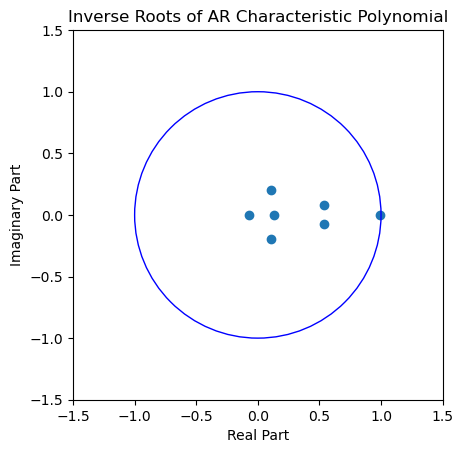

In [ ]:
# Calculate inverse roots
inverse_roots = 1 / roots

# Create a new figure
plt.figure()

# Plot the real part on the x-axis and the imaginary part on the y-axis
plt.scatter(inverse_roots.real, inverse_roots.imag)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Set the x and y limits to be the same
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

# Set the aspect ratio to be equal, so the circle looks like a circle
plt.gca().set_aspect('equal', adjustable='box')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Inverse Roots of AR Characteristic Polynomial')

# Show the plot
plt.show()

In [ ]:
# Assuming `svar_results` is the fitted results object
# Retrieve residuals and variable names from the fitted SVAR results
residuals = svar_results.resid
variable_names = svar_results.names

# Example of the Jarque-Bera test for normality
from scipy.stats import jarque_bera

for i, var in enumerate(variable_names):
    jb_test = jarque_bera(residuals[:, i])
    print(f"Normality Test for {var}: Statistic={jb_test[0]}, p-value={jb_test[1]}")

# we need to correct outliers, variables deviate from normality

Normality Test for Futures Shock: Statistic=6083.540315438685, p-value=0.0
Normality Test for M2SL: Statistic=3640.7075593539253, p-value=0.0
Normality Test for PCEPI: Statistic=113.17659534642569, p-value=2.654694684443821e-25
Normality Test for 10Y Treasury: Statistic=7.026923444472042, p-value=0.029793598552053567
Normality Test for GDP: Statistic=36633.87991677968, p-value=0.0
Normality Test for Unemployment: Statistic=508241.546416403, p-value=0.0
Normality Test for SPX Total: Statistic=77.4930615543836, p-value=1.4879745067549467e-17


In [ ]:
print(svar_results.test_normality())

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 39864.081, critical value: 23.685>, p-value: 0.000>


In [ ]:
print(svar_results.test_whiteness())

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 687.762, critical value: 490.960>, p-value: 0.000>


In [ ]:
#granger causality

In [ ]:
import statsmodels.stats.diagnostic as smd
import pandas as pd

# Access the residuals and predictor variables from the fitted SVAR model
residuals = pd.DataFrame(svar_results.resid, columns=svar_results.names)

# Retrieve endogenous variables used as predictors
predictors = pd.DataFrame(svar_results.endog, columns=svar_results.names)

# Conduct the White test for each residual series
for i, col in enumerate(residuals.columns):
    white_test = smd.het_white(residuals[col], predictors)
    print(f"White Test for {col}: LM Statistic={white_test[0]}, p-value={white_test[1]}")


ValueError: resid is required to have shape (384, 1) but has shape (383, 1)

In [ ]:
# Example of performing the Breusch-Godfrey test for autocorrelation
import statsmodels.stats.diagnostic as smd

# Perform the Breusch-Godfrey test
lm_test = smd.acorr_breusch_godfrey(svar_results, nlags=10)

# Print the results of the test
print(f"Breusch-Godfrey Test: LM Statistic={lm_test[0]}, p-value={lm_test[1]}")


ValueError: Model resid must be a 1d array. Cannot be used on multivariate models.

<Axes: title={'center': 'Local Projection for SPX Total'}, xlabel='Horizon (Periods Ahead)', ylabel='Response'>

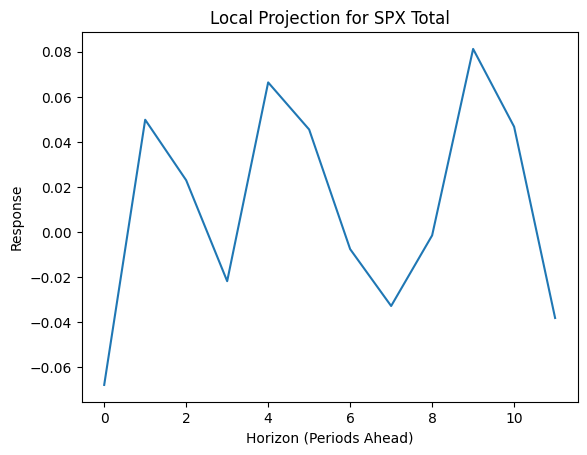

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Set the shock variable (assumed exogenous)
shock_variable = 'Futures Shock'

horizons = range(0, 12)

# Initialize a dictionary to store results for each response variable
responses = {var: [] for var in spy_data_ordered.columns if var != shock_variable}

# Fit a local projection model for each horizon and response variable
for h in horizons:
    for response_var in responses:
        # Shift the response variable by the horizon value
        target = spy_data_ordered[response_var].shift(-h).dropna()

        # Ensure predictors are aligned with the shifted target
        predictors = spy_data_ordered[[shock_variable]].loc[target.index]

        # Add a constant term to predictors
        predictors = sm.add_constant(predictors)

        # Fit an Ordinary Least Squares (OLS) regression
        model = sm.OLS(target, predictors).fit()

        # Append the coefficient for the shock variable
        responses[response_var].append(model.params[shock_variable])

# Convert responses to a DataFrame for easier analysis
response_df = pd.DataFrame(responses, index=horizons)

response_df['SPX Total'].plot(title="Local Projection for SPX Total", xlabel="Horizon (Periods Ahead)", ylabel="Response")

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults

# Assuming 'data' is a dictionary containing the required variables

# Concatenate all the variables into a DataFrame
df = pd.DataFrame(data['y'], columns=[f'y{i+1}' for i in range(data['y'].shape[1])])
df['m'] = spy_data_ordered[['Futures Shock', 'SPX Shock']].values.flatten()
df = pd.concat([df, pd.DataFrame(data['w'], columns=[f'w{i+1}' for i in range(data['w'].shape[1])])], axis=1)

# Assuming df is your DataFrame

# Fit VAR model
model = VAR(df)
results = model.fit(maxlags=prior['lags'])

# Extract posterior results
beta = results.coefs
sigma = results.sigma_u

# Assuming 'ndraws' is the number of posterior draws
beta_draws = np.empty((beta.shape[0], beta.shape[1], ndraws))
sigma_draws = np.empty((sigma.shape[0], sigma.shape[1], ndraws))

for i in range(ndraws):
    # Simulate residuals
    residuals = np.random.multivariate_normal(np.zeros(N), sigma, T)

    # Simulate data
    simulated_data = np.zeros((T, N))
    simulated_data[:prior['lags'], :] = data['y'][:prior['lags'], :]
    for t in range(prior['lags'], T):
        lagged_data = np.concatenate([simulated_data[t-1:t-prior['lags']-1:-1, :], data['w'][t-1:t-prior['lags']-1:-1, :]], axis=1)
        simulated_data[t, :] = np.dot(beta.T, lagged_data[t, :]) + residuals[t, :]

    # Fit VAR model to simulated data
    model = VAR(pd.DataFrame(simulated_data, columns=df.columns))
    results = model.fit(maxlags=prior['lags'])

    # Store posterior draws
    beta_draws[:, :, i] = results.coefs
    sigma_draws[:, :, i] = results.sigma_u


KeyError: 'y'